<a href="https://colab.research.google.com/github/NaokiDohi/senior_thesis/blob/master/J_diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## improt

In [ ]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## load model

In [ ]:
#load_model('model.h5')

#load and reshape data

In [ ]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")
#dataの更新は21：３０に行われる？

Dude!! This file is already download


In [ ]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
151,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,7,7,11,15,20,20,20,22,23,23,23,24,24,26,27,28,33,43,54,60,67,79,85,95,112,137,149,160,173,192,...,52471,53818,55051,56074,56717,57636,58728,59900,60949,61916,62658,63158,63888,64779,65653,66499,67353,67958,68396,69023,69619,70278,70866,71467,71918,72213,72724,73264,73916,74558,75206,75646,75914,76446,76997,77488,78061,78662,79142,79462


In [ ]:
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-09-17    77488
2020-09-18    78061
2020-09-19    78662
2020-09-20    79142
2020-09-21    79462
Name: 151, Length: 244, dtype: int64


#元データのプロットと画像保存

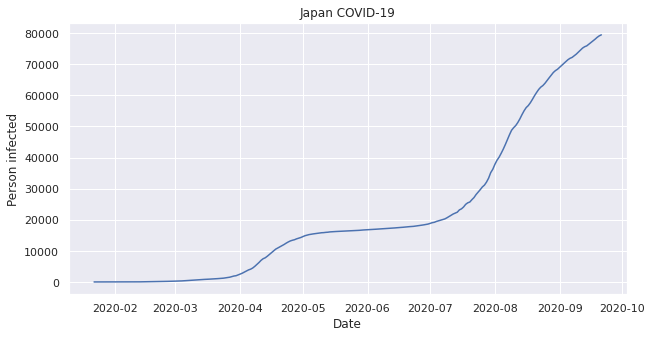

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title("Japan COVID-19")
plt.xlabel("Date")
plt.ylabel("Person infected")
plt.grid(True)
plt.show()

In [ ]:
#ファイル保存
fname ='original.png'
plt.savefig(fname) 
plt.close() 

# residual diff

In [ ]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff

2020-01-22      NaN
2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
              ...  
2020-09-17    491.0
2020-09-18    573.0
2020-09-19    601.0
2020-09-20    480.0
2020-09-21    320.0
Name: 151, Length: 244, dtype: float64

In [ ]:
data_at_japan_diff = data_at_japan_diff.dropna()

In [ ]:
data_at_japan_diff

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-09-17    491.0
2020-09-18    573.0
2020-09-19    601.0
2020-09-20    480.0
2020-09-21    320.0
Name: 151, Length: 243, dtype: float64

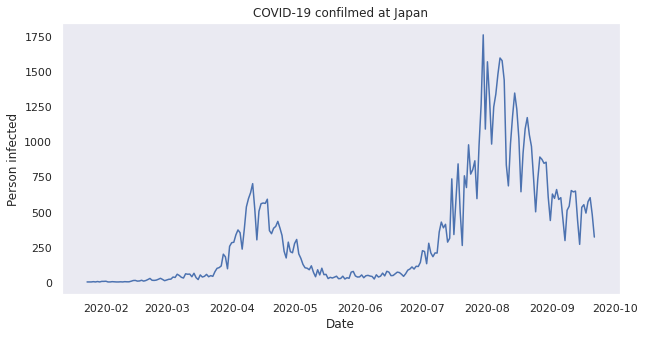

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan')
plt.xlabel('Date')
plt.ylabel('Person infected')
plt.grid()
plt.show()

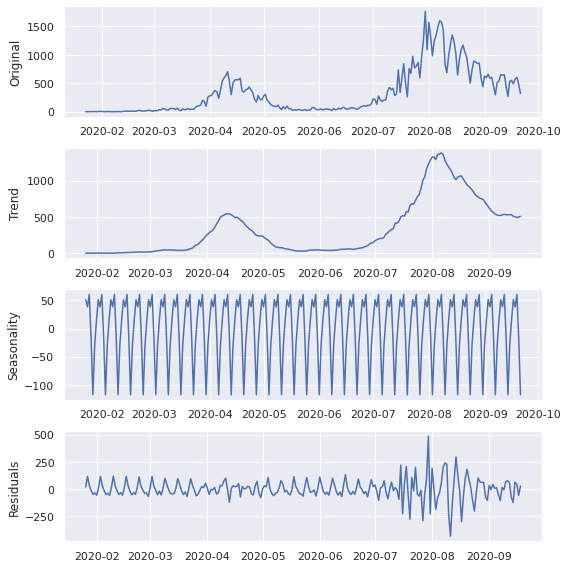

In [ ]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [ ]:
y = data_at_japan_diff.values.astype(float)

In [ ]:
len(y)

243

In [ ]:
test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

In [ ]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

In [ ]:
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

In [ ]:
window = 7#学習時のウィンドウサイズ

In [ ]:
study_data, correct_data  = sequence_creator(train_normalized, window)

In [ ]:
n_out = 1
n_hidden = 300#256 #512

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, window, n_out), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_hidden, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_hidden, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_out))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["acc"])# optimizer="rmsprop"
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 300)            362400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 300)            721200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 300)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
epochs=100#200
history = model.fit(study_data, correct_data, batch_size=300, epochs=epochs, validation_split=0.1, callbacks=[early_stopping], verbose=0)

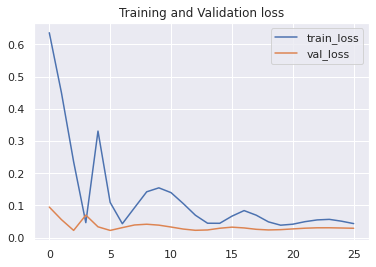

In [ ]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

In [ ]:
datetime = dt.datetime.now()
today = f'{datetime.year}-{datetime.month}-{datetime.day}'
today = pd.to_datetime(today)
print(today)

2020-09-23 00:00:00


In [ ]:
the_week_before_last = f'{datetime.year}-{datetime.month}-{datetime.day-16}'
the_week_before_last= pd.to_datetime(the_week_before_last)
the_week_before_last

Timestamp('2020-09-07 00:00:00')

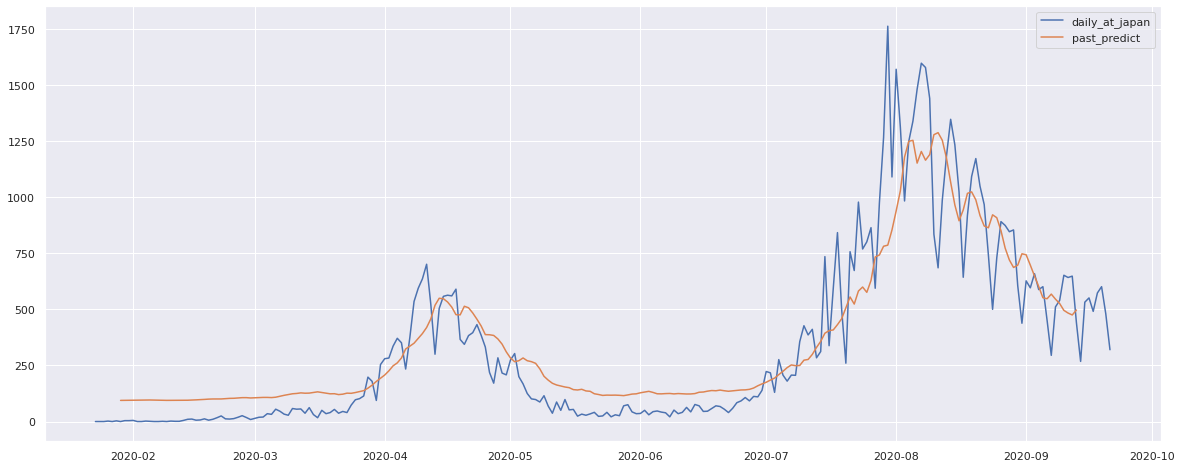

In [ ]:
plt.figure(figsize=(20,8))#サンプル数が多いので通常のpltでは表示がおかしくなるので適当な引数を渡して拡大表示
x0 = np.arange('2020-01-22',the_week_before_last, dtype='datetime64[D]').astype('datetime64[D]')
plt.plot(data_at_japan_diff, label='daily_at_japan')
plt.plot(x0+7,train_inverse,label='past_predict')
plt.legend(loc='upper left')

In [ ]:
upcoming_future=7

In [ ]:
#初期データの作成
predictions = train_normalized[-window:].tolist()
print("predictions:" + str(predictions))
print("____________________________________________________________________________")
#Kerasの入力形状を生成
predictions = np.array(predictions).reshape(-1, window, 1)
print("predictions:")
print("   ")
print(predictions)
print("   ")
#predicted_future = predictions
#print(predicted_future)

predictions:[[-0.41997729852440413], [-0.3870601589103292], [-0.2599318955732123], [-0.2712826333711691], [-0.264472190692395], [-0.5005675368898979], [-0.695800227014756]]
____________________________________________________________________________
predictions:
   
[[[-0.4199773 ]
  [-0.38706016]
  [-0.2599319 ]
  [-0.27128263]
  [-0.26447219]
  [-0.50056754]
  [-0.69580023]]]
   


In [ ]:
#予測をfor文で
for i in range(upcoming_future):
  print(str(i+1) + "回目のforループ")
  predicted_future = model.predict(predictions)
  print("predicted_future:" + str(predicted_future) + "    " + "row_predicted_future:"+ str(scaler.inverse_transform(np.array(predicted_future).reshape(-1,1))))
  print("____________________________________________________________________________")
  predictions = predictions.tolist()
  predictions = np.append(predictions,predicted_future)
  print("predictions:" + str(predictions))
  print("____________________________________________________________________________")
  predictions = predictions[-window:]
  print("predictions:" + str(predictions))
  print("____________________________________________________________________________")
  predictions = np.array(predictions).reshape(-1, window, 1)
  print("predictions:")
  print("   ")
  print(predictions)
  print("   ")
  if(i != window-1):
    print("____________________________________________________________________________")

1回目のforループ
predicted_future:[[-0.3818859]]    row_predicted_future:[[544.55853]]
____________________________________________________________________________
predictions:[-0.4199773  -0.38706016 -0.2599319  -0.27128263 -0.26447219 -0.50056754
 -0.69580023 -0.38188589]
____________________________________________________________________________
predictions:[-0.38706016 -0.2599319  -0.27128263 -0.26447219 -0.50056754 -0.69580023
 -0.38188589]
____________________________________________________________________________
predictions:
   
[[[-0.38706016]
  [-0.2599319 ]
  [-0.27128263]
  [-0.26447219]
  [-0.50056754]
  [-0.69580023]
  [-0.38188589]]]
   
____________________________________________________________________________
2回目のforループ
predicted_future:[[-0.38002384]]    row_predicted_future:[[546.199]]
____________________________________________________________________________
predictions:[-0.38706016 -0.2599319  -0.27128263 -0.26447219 -0.50056754 -0.69580023
 -0.38188589 -0.38002384

In [ ]:
predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions_infected_pepole

array([[544.55853426],
       [546.19899952],
       [539.6859481 ],
       [509.98646408],
       [481.82859206],
       [452.30709642],
       [462.8357957 ]])

In [ ]:
lastweek = f'{datetime.year}-{datetime.month}-{datetime.day-7}'
lastweek= pd.to_datetime(lastweek)
lastweek

Timestamp('2020-09-16 00:00:00')

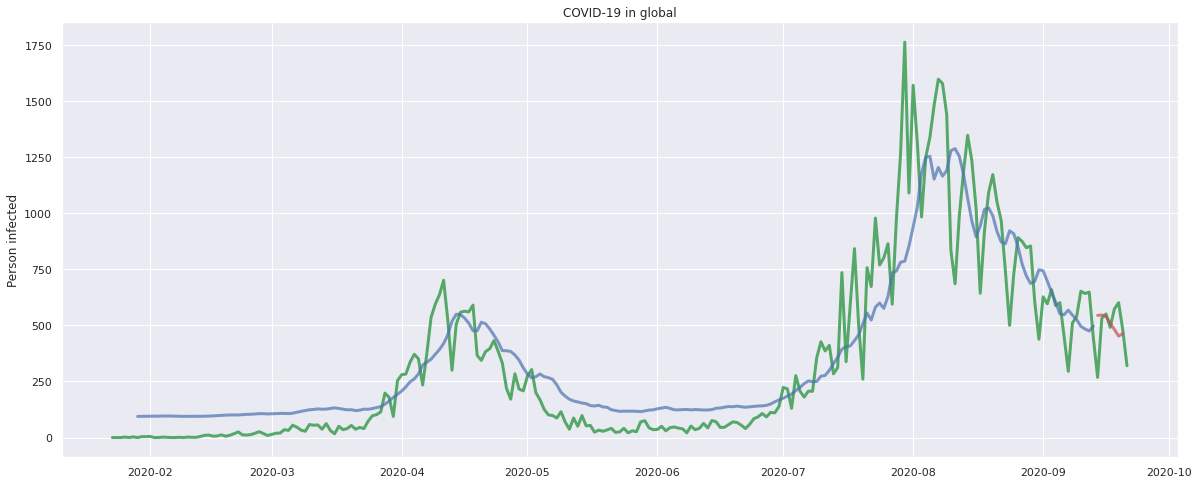

In [ ]:
x = np.arange(lastweek, today, dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in global")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(data_at_japan_diff,'g',lw=3,label='daily_at_japan')
plt.plot(x0+7,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')
plt.plot(x-2, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score
train_data = train_original_data[7:]
train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
print('train_r2:'+str(train_r2))

print('test_mae:'+str(test_mae))
print('test_mae:'+str(test_mse))
print('test_mae:'+str(test_rmse))
print('test_mae:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae:118.81254744217385
train_mse:27180.51925737574
train_rmae:164.86515477012037
train_r2:0.8273645203916625
test_mae:59.82273228253637
test_mae:5984.654221695199
test_mae:77.36054693249783
test_mae:0.18980611341113984
